# 🌲 Random Forest Models for Drug Sensitivity Prediction

This notebook trains a **Random Forest (RF)** regression model per drug using gene expression features (PCA or HVGs). RFs are robust, handle nonlinearities, and offer good interpretability with minimal hyperparameter tuning. We use **5-fold cross-validation** to evaluate each model’s performance with RMSE and R² metrics.



In [1]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
NUM_PCS = 20

# Choose your dataset (PCA or HVG)
DATA_PATH = "../../../data/processed/gdsc_pancancer_embeddings_30_pcs_tissue_growth.parquet"
data = pd.read_parquet(DATA_PATH)

print("✅ Dataset loaded:", data.shape)


✅ Dataset loaded: (83624, 45)


### 🔁 Train One Random Forest Per Drug

For each drug, we train a separate RF model using its associated (cell line, IC50, features) data. We use train-test split and evaluate with RMSE and R².


In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr

# Create result folders
os.makedirs("rf/models", exist_ok=True)
os.makedirs("rf/results", exist_ok=True)

non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
gene_cols = [col for col in data.columns if col not in non_features]

kf = KFold(n_splits=10, shuffle=True, random_state=42)

results = []

for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 100:
        print(f"⚠️ Skipped drug {drug_id} (samples: {df.shape[0]})")
        continue

    X = df[gene_cols].values.astype("float64")
    y = df["LN_IC50"].values.astype("float64")

    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    )

    # Perform CV with prediction concatenation
    y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)

    # Compute metrics
    r2 = r2_score(y, y_pred)
    pearson_r, p_val = pearsonr(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)

    print(f"\n🌲 Drug {drug_id} | Samples: {len(df)}")
    print(f"  ➤ Global R²: {r2:.4f}")
    print(f"  ➤ Pearson r: {pearson_r:.4f} (p={p_val:.2e})")
    print(f"  ➤ RMSE: {rmse:.4f}")

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "r2_global": r2,
        "pearson_r": pearson_r,
        "pearson_pval": p_val,
        "rmse": rmse
    })

    # Optionally save the last fitted model for this drug on all data
    model.fit(X, y)
    # joblib.dump(model, f"rf/models/rf_drug_{drug_id}.pkl")

⚠️ Skipped drug 1 (samples: 24)
⚠️ Skipped drug 3 (samples: 23)
⚠️ Skipped drug 5 (samples: 26)
⚠️ Skipped drug 6 (samples: 27)
⚠️ Skipped drug 9 (samples: 26)
⚠️ Skipped drug 11 (samples: 26)
⚠️ Skipped drug 17 (samples: 25)
⚠️ Skipped drug 29 (samples: 26)
⚠️ Skipped drug 30 (samples: 26)
⚠️ Skipped drug 32 (samples: 26)
⚠️ Skipped drug 34 (samples: 27)
⚠️ Skipped drug 35 (samples: 27)
⚠️ Skipped drug 37 (samples: 27)
⚠️ Skipped drug 38 (samples: 27)
⚠️ Skipped drug 41 (samples: 26)
⚠️ Skipped drug 45 (samples: 26)
⚠️ Skipped drug 51 (samples: 26)
⚠️ Skipped drug 52 (samples: 26)
⚠️ Skipped drug 53 (samples: 26)
⚠️ Skipped drug 54 (samples: 26)
⚠️ Skipped drug 55 (samples: 26)
⚠️ Skipped drug 56 (samples: 26)
⚠️ Skipped drug 59 (samples: 26)
⚠️ Skipped drug 60 (samples: 25)
⚠️ Skipped drug 62 (samples: 26)
⚠️ Skipped drug 63 (samples: 26)
⚠️ Skipped drug 64 (samples: 26)
⚠️ Skipped drug 71 (samples: 26)
⚠️ Skipped drug 83 (samples: 26)
⚠️ Skipped drug 86 (samples: 26)
⚠️ Skipped drug

In [4]:
results_df = pd.DataFrame(results)
results_df.to_csv(f"rf/results/scfoundation_10_fold_embeddings_30_pcs_tissue_growth.csv", index=False)

print("📁 Saved to rf/results/model_performance_summary.csv")
results_df.head()


📁 Saved to rf/results/model_performance_summary.csv


,DRUG_ID,n_samples,r2_global,pearson_r,pearson_pval,rmse
0,133,132,0.062179,0.265119,0.002125,1.640831
1,134,132,0.018867,0.214437,0.013547,1.894260
2,135,131,0.002719,0.188906,0.030703,2.606634
3,136,133,-0.026048,0.136858,0.116223,1.526373
4,140,133,0.007956,0.185500,0.032542,1.631817


### 📊 Distribution of RF Model Performance
We now visualize the RMSE and R² scores to analyze how well the RF models performed across all drugs.


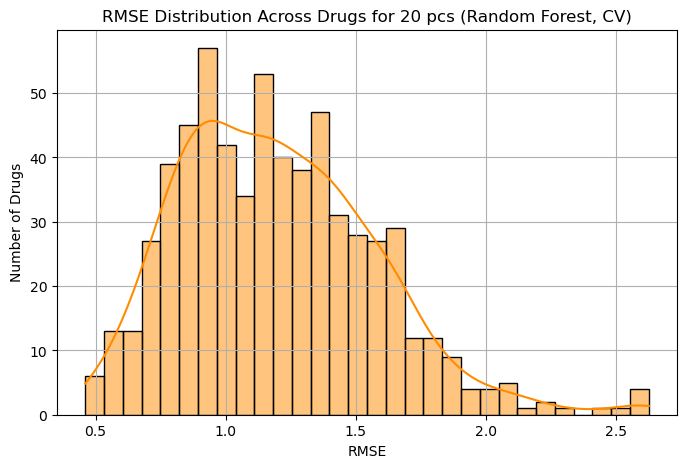

In [5]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse"], kde=True, bins=30, color="darkorange")
plt.title(f"RMSE Distribution Across Drugs for {NUM_PCS} pcs (Random Forest, CV)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()

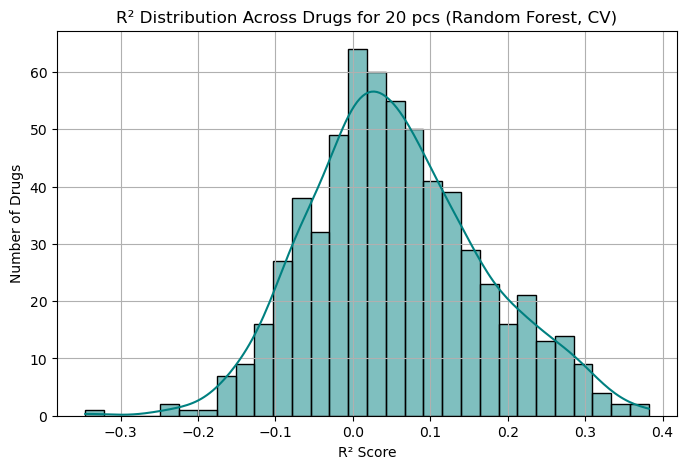

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_global"], kde=True, bins=30, color="teal")
plt.title(f"R² Distribution Across Drugs for {NUM_PCS} pcs (Random Forest, CV)")
plt.xlabel("R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()

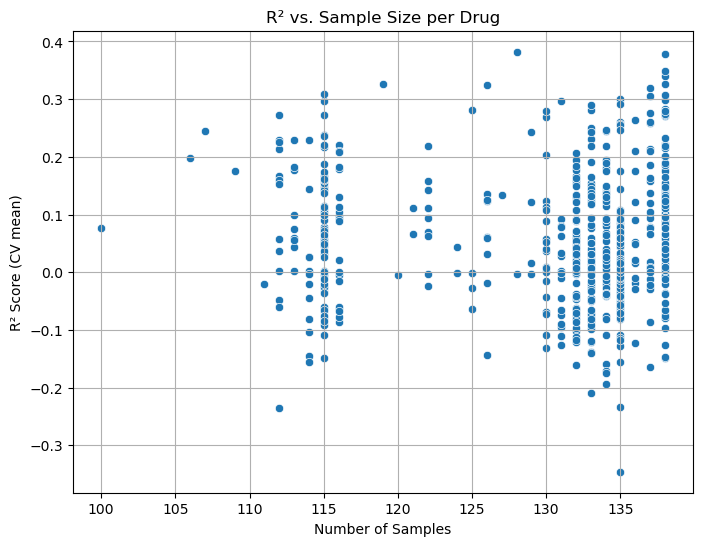

In [7]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="n_samples", y="r2_global", data=results_df)
plt.title("R² vs. Sample Size per Drug")
plt.xlabel("Number of Samples")
plt.ylabel("R² Score (CV mean)")
plt.grid(True)
plt.show()


In [8]:
from scipy.stats import pearsonr, spearmanr

# Pearson (linear)
pearson_corr, pval_pearson = pearsonr(results_df["n_samples"], results_df["r2_global"])
print(f"📊 Pearson r = {pearson_corr:.3f} (p = {pval_pearson:.3g})")

# Spearman (rank-based, robust to non-linearities)
spearman_corr, pval_spearman = spearmanr(results_df["n_samples"], results_df["r2_global"])
print(f"📊 Spearman ρ = {spearman_corr:.3f} (p = {pval_spearman:.3g})")


📊 Pearson r = -0.028 (p = 0.481)
📊 Spearman ρ = 0.052 (p = 0.197)


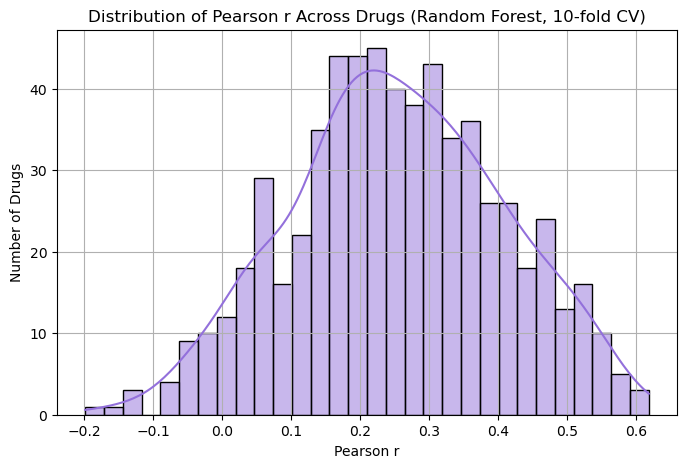

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["pearson_r"], kde=True, bins=30, color="mediumpurple")
plt.title("Distribution of Pearson r Across Drugs (Random Forest, 10-fold CV)")
plt.xlabel("Pearson r")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()


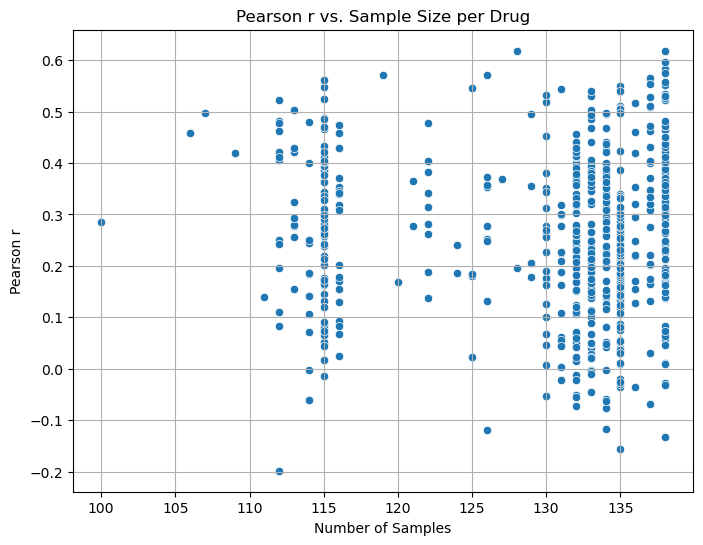

In [10]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="n_samples", y="pearson_r")
plt.title("Pearson r vs. Sample Size per Drug")
plt.xlabel("Number of Samples")
plt.ylabel("Pearson r")
plt.grid(True)
plt.show()
plt.close()


In [11]:
pearson_corr_r, pval_pearson_r = pearsonr(results_df["n_samples"], results_df["pearson_r"])
spearman_corr_r, pval_spearman_r = spearmanr(results_df["n_samples"], results_df["pearson_r"])

print(f"📊 Pearson r (sample size vs Pearson r) = {pearson_corr_r:.3f} (p = {pval_pearson_r:.3g})")
print(f"📊 Spearman ρ (sample size vs Pearson r) = {spearman_corr_r:.3f} (p = {pval_spearman_r:.3g})")


📊 Pearson r (sample size vs Pearson r) = -0.039 (p = 0.331)
📊 Spearman ρ (sample size vs Pearson r) = 0.041 (p = 0.309)


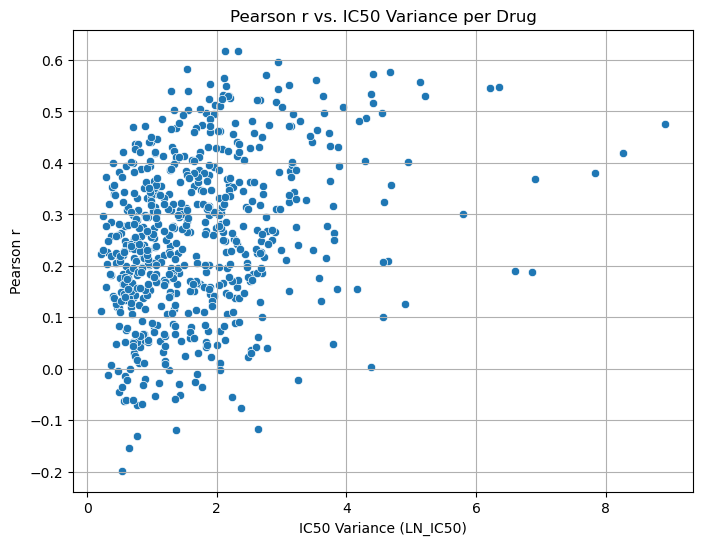

Pearson r (IC50 variance vs Pearson r) = 0.317 (p = 5.13e-16)
Spearman ρ (IC50 variance vs Pearson r) = 0.314 (p = 9.4e-16)


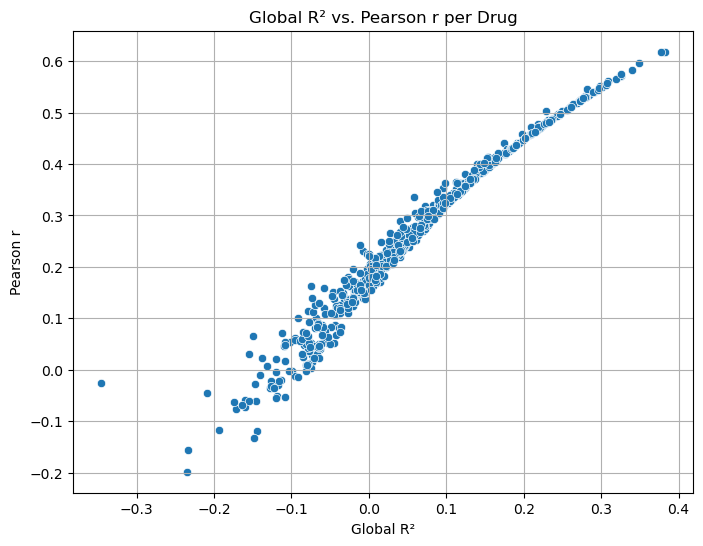


Top 5 drugs by Pearson r:
      DRUG_ID  pearson_r  r2_global      rmse
229     1061   0.618361   0.382188  1.141444
246     1089   0.616900   0.377782  1.198980
603     2546   0.596524   0.348801  1.380348
597     2540   0.582803   0.339406  1.004326
601     2544   0.575990   0.325649  1.769221

Bottom 5 drugs by Pearson r:
      DRUG_ID  pearson_r  r2_global      rmse
538     2112  -0.198083  -0.235378  0.813070
92       281  -0.155004  -0.233663  0.883947
502     1927  -0.131771  -0.147901  0.938069
372     1527  -0.119004  -0.144306  1.244770
86       273  -0.116952  -0.193708  1.769202

Saved top/bottom drugs summary to rf/results/top_bottom_pearson_r.csv

Top 20 features for best drug (1061.0):
 0                  0.357920
Tissue_Skin        0.073527
day4_day1_ratio    0.054683
14                 0.046179
22                 0.041720
27                 0.040238
7                  0.032691
5                  0.031108
15                 0.026545
21                 0.022094
11      

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# ✅ 1) Pearson r vs. IC50 variance
# Already merged? If not, do:
variances = data.groupby("DRUG_ID")["LN_IC50"].var()
results_df = results_df.merge(variances.rename("ic50_variance"), on="DRUG_ID")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="ic50_variance", y="pearson_r")
plt.title("Pearson r vs. IC50 Variance per Drug")
plt.xlabel("IC50 Variance (LN_IC50)")
plt.ylabel("Pearson r")
plt.grid(True)
plt.show()

# Compute correlations
pearson_corr_var, pval_pearson_var = pearsonr(results_df["ic50_variance"], results_df["pearson_r"])
spearman_corr_var, pval_spearman_var = spearmanr(results_df["ic50_variance"], results_df["pearson_r"])
print(f"Pearson r (IC50 variance vs Pearson r) = {pearson_corr_var:.3f} (p = {pval_pearson_var:.3g})")
print(f"Spearman ρ (IC50 variance vs Pearson r) = {spearman_corr_var:.3f} (p = {pval_spearman_var:.3g})")

# ✅ 2) R² vs. Pearson r consistency plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="r2_global", y="pearson_r")
plt.title("Global R² vs. Pearson r per Drug")
plt.xlabel("Global R²")
plt.ylabel("Pearson r")
plt.grid(True)
plt.show()

# ✅ 3) Identify top & bottom 5 drugs by Pearson r
top5 = results_df.nlargest(5, "pearson_r")
bottom5 = results_df.nsmallest(5, "pearson_r")
print("\nTop 5 drugs by Pearson r:\n", top5[["DRUG_ID", "pearson_r", "r2_global", "rmse"]])
print("\nBottom 5 drugs by Pearson r:\n", bottom5[["DRUG_ID", "pearson_r", "r2_global", "rmse"]])

# ✅ 4) Optional: Save top/bottom drugs table
top_bottom = pd.concat([top5.assign(rank="top5"), bottom5.assign(rank="bottom5")])
top_bottom.to_csv("rf/results/top_bottom_pearson_r.csv", index=False)
print("\nSaved top/bottom drugs summary to rf/results/top_bottom_pearson_r.csv")

# ✅ 5) Optional: Feature importances for best vs. worst
# Refit models for top & bottom example drugs if needed:
# Example for top drug:
best_drug_id = top5.iloc[0]["DRUG_ID"]
df_best = data[data["DRUG_ID"] == best_drug_id].dropna(subset=["LN_IC50"])
X_best = df_best[gene_cols].values
y_best = df_best["LN_IC50"].values

model_best = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_best.fit(X_best, y_best)

importances = pd.Series(model_best.feature_importances_, index=gene_cols)
top_genes = importances.sort_values(ascending=False).head(20)
print(f"\nTop 20 features for best drug ({best_drug_id}):\n", top_genes)
top_genes.to_csv(f"rf/results/top_features_drug_{best_drug_id}.csv")
